In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import theano
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 965M (0000:01:00.0)
Using TensorFlow backend.


In [103]:
# Generate training data
#
# One time series is a COS function, influenced by a separate scale signal time series which is a set of multipliers (aka scales)
# for the COS function, that changes periodically. Furthermore, to validate that LSTM can spot changes that influence the
# time series ahead of time (i.e. changes acting as leading indicators), the COS time series is setup to adjusts its scale 
# with a 25 steps delay after the scale signal time series changes.


length = 3000 # Time series Length
scales = [0.5, 1, 1.5] # How much COS func will be scaled
scale_step = 100 # Change scale frequency
steps_ahead = 25 # How far ahead scale changes before it affects COS func

df = pd.DataFrame(columns = ['Series', 'Scale Signal', 'Scale Signal Squared'])

scale_signal = 1 # initial settings
scale = 1


for i in range(length):
    if (i + steps_ahead) % scale_step == 0:
        scale_signal = scales[random.randint(0,2)]
        
    if i % scale_step == 0:
        scale = scale_signal
        
    df.loc[i, 'Series'] = np.cos(i / 4.0) * scale
    df.loc[i, 'Scale Signal'] = scale_signal
    df.loc[i, 'Scale Signal Squared'] = scale_signal ** 2
    
df

,Series,Scale Signal,Scale Signal Squared
0,1,1,1
1,0.968912,1,1
2,0.877583,1,1
3,0.731689,1,1
4,0.540302,1,1
5,0.315322,1,1
6,0.0707372,1,1
7,-0.178246,1,1
8,-0.416147,1,1
9,-0.628174,1,1


In [111]:
data = df.values

examples = 200 # how far to look back
y_examples = 100 # how far to predict in the future
nb_samples = len(data) - examples - y_examples

input_list = [np.expand_dims(np.atleast_2d(data[i: examples + i, :]), axis = 0) for i in range(nb_samples)]
input_mat = np.concatenate(input_list, axis = 0)

np.asarray(input_list).shape, np.asarray(input_mat).shape

((2700, 1, 200, 3), (2700, 200, 3))

In [44]:
np.asarray(input_list).shape, np.asarray(input_mat).shape

((2700, 1, 200, 3), (2700, 200, 3))

In [112]:
#use the tail of the series as the test data
df_test = pd.DataFrame(df[-examples:])

test_data = df_test.values
test_input_list = [np.expand_dims(np.atleast_2d(test_data[len(test_data)-examples:len(test_data),:]), axis=0) for i in range(1)]
test_input_mat = np.concatenate(test_input_list, axis = 0)

# target - the first column in the df dataframe
target_list = [np.atleast_2d(data[i+examples:examples+i+y_examples,0]) for i in range(nb_samples)]
target_mat = np.concatenate(target_list, axis = 0)

np.asarray(test_input_list).shape, np.asarray(test_input_mat).shape, np.asarray(target_list).shape, np.asarray(target_mat).shape

((1, 1, 200, 3), (1, 200, 3), (2700, 1, 100), (2700, 100))

In [107]:
#Set up model
features = input_mat.shape[2]
hidden = 128
epochs = 25
batch_size = 100
validation_split = 0.05

model = Sequential()
model.add(LSTM(hidden, input_shape = (examples, features)))
model.add(Dropout(.2))
model.add(Dense(y_examples))
model.add(Activation('linear'))
model.compile(loss = 'mse', optimizer = 'rmsprop')

#Train
hist = model.fit(input_mat, target_mat, epochs = epochs, batch_size = batch_size, 
                 validation_split = validation_split, verbose = 1)

predicted = model.predict(test_input_mat)

df_val_loss = pd.DataFrame(hist.history['val_loss'])
df_val_loss.plot()

df_predicted = pd.DataFrame(predicted).T
df_predicted.columns = ['Predicted 1']

df_result = pd.concat([df[-300:], df_predicted], ignore_index = True)
df_result.plot()

plt.show()

Train on 2565 samples, validate on 135 samples
Epoch 1/25
2565/2565 [==============================] - 37s - loss: 0.2866 - val_loss: 0.0869
Epoch 2/25
2565/2565 [==============================] - 28s - loss: 0.0930 - val_loss: 0.0643
Epoch 3/25
2565/2565 [==============================] - 29s - loss: 0.0686 - val_loss: 0.0529
Epoch 4/25
2565/2565 [==============================] - 28s - loss: 0.0633 - val_loss: 0.0380
Epoch 5/25
2565/2565 [==============================] - 29s - loss: 0.0593 - val_loss: 0.0446
Epoch 6/25
2565/2565 [==============================] - 28s - loss: 0.0566 - val_loss: 0.0794
Epoch 7/25
2565/2565 [==============================] - 29s - loss: 0.0532 - val_loss: 0.0478
Epoch 8/25
2565/2565 [==============================] - 28s - loss: 0.0524 - val_loss: 0.0545
Epoch 9/25
2565/2565 [==============================] - 29s - loss: 0.0512 - val_loss: 0.0456
Epoch 10/25
2565/2565 [==============================] - 28s - loss: 0.0471 - val_loss: 0.0364
Epoch 11/25


ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [99]:
test_input_list = [np.expand_dims(np.atleast_2d(test_data[len(test_data)-examples:len(test_data),:]), axis=0) for i in range(1)]
test_input_mat = np.concatenate(test_input_list, axis = 0)

# target - the first column in the df dataframe
target_list = [np.atleast_2d(data[i+examples:examples+i+y_examples,0]) for i in range(nb_samples)]
target_mat = np.concatenate(target_list, axis = 0)

In [75]:
input_list[3][0][2]

array([0.31532236239526867, 1, 1], dtype=object)

In [106]:
df_result

,Predicted 1,Predicted 2,Scale Signal,Scale Signal Squared,Series
0,NaN,NaN,1,1,1
1,NaN,NaN,1,1,0.968912
2,NaN,NaN,1,1,0.877583
3,NaN,NaN,1,1,0.731689
4,NaN,NaN,1,1,0.540302
5,NaN,NaN,1,1,0.315322
6,NaN,NaN,1,1,0.0707372
7,NaN,NaN,1,1,-0.178246
8,NaN,NaN,1,1,-0.416147
9,NaN,NaN,1,1,-0.628174


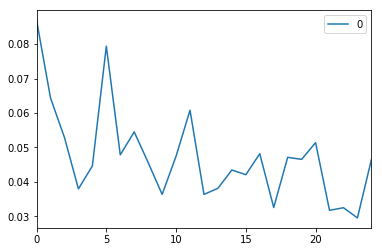

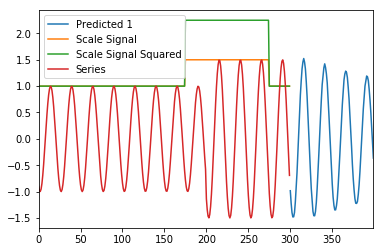

In [108]:
df_predicted = pd.DataFrame(predicted).T
df_predicted.columns = ['Predicted 1']

df_result = pd.concat([df[-300:], df_predicted], ignore_index = True)
df_result.plot()

plt.show()

In [110]:
df_result

,Predicted 1,Scale Signal,Scale Signal Squared,Series
0,NaN,1,1,-0.903718
1,NaN,1,1,-0.981544
2,NaN,1,1,-0.998343
3,NaN,1,1,-0.953069
4,NaN,1,1,-0.848538
5,NaN,1,1,-0.69125
6,NaN,1,1,-0.490982
7,NaN,1,1,-0.260188
8,NaN,1,1,-0.0132165
9,NaN,1,1,0.234577
